<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
        <img src="http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" style="height:75px; margin-left:0px" />
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center"> Drug-Temporal words Association and rolling up on User level </h1><br>
        <div style="width: 100%; text-align: center; display: inline-block;"><i>Author:</i> <strong>Varun Behl</strong> </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Created: </i>
            <time datetime="2018-02-14" pubdate>13th Feb 2018</time>
            <i>Modified: </i>
            <time datetime="2018-02-21" pubdate>21st Feb 2018</time>
        </div>
    </div>
</div>

# Objective

The aim of Drug and Temporal words association is to check whether given drug and temporal mention are associated to each other or not . The association is carried out by graphical method of calculating shortest path between two words . This will help us assign mentioned drug a date , which according to our process is the date on which the drug treatment was actually started

Following are the list of operations carried out : - 
* Converting the ctakes CoNLL format to a python dict
* Creating a list of tuples(a,b) : a - head of a token , b - tail of token word
* List of tuples is converted to a graph using networkx package 
* shortest path is calcualted between Drug mention (source) and Temporal word ( Target ).

In [13]:
# Importing the required packages
import pandas as pd
import numpy as np
import re
import re
import ast
import nltk
import networkx as nx
from practnlptools.tools import Annotator
import xmltodict

### Shortest path algorithm for association of drug and temporal


### Below code for Drug-Temporal association

In [1]:

# Function to check whether the word token from Conll output is a drug word
def isDrugMention(token):
    # custom drug list
    with open("updated_drugs_v2.txt","r") as f:
        drug = f.read()
    try:
        
        if len(re.findall(r"\b(?=\w)"+token+r"\b(?!\w)",drug))>=1:
            #print 1
            return 1
    except:
        return 0

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def getmin(l,wordsList):
    if(len(l)==len(wordsList)):
        if len(l)==1:
            return l
        else: 
            return l[0]
    else:
        return None


def xml_input(unique_id):
    
    xmlfile = 'post'+'_'+unique_id+'.txt.xml'

    with open('C:/Users/varun.behl/Documents/test_plain_text_updated/output_from_domino/'+xmlfile) as fd:
        doc2 = xmltodict.parse(fd.read())

    _id = []
    wi =[]
    word = []
    lemma = []
    cpostag = []
    head = []
    deprel = []
    token_dict = {}
    word_index = {}
    conll_pattern = []
    conll_index = []

    sentence_start = []
    sentence_start.append(1)
    for i in range(1,len(doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'])):
        if doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@id'].encode("utf-8")=='0':
            sentence_start.append(prev_token+1)
            continue
        token_dict[(doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@_id']).encode("utf-8")]=[i,(doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@cpostag']).encode("utf-8")]
        _id.append((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@_id']).encode("utf-8"))
        wi.append((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@id']).encode("utf-8"))
        wix = doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@id'].encode("utf-8")
        head.append((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@_ref_head']).encode("utf-8"))
        cpostag.append((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@cpostag']).encode("utf-8"))
        word = doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@form'].encode("utf-8")
        if isDrugMention((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@form']).encode("utf-8")):
            conll_pattern.append('D')
            conll_index.append(int((doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@id']).encode("utf-8"))-1)
        prev_token=int(doc2['CAS']['org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'][i]['@id'])
        # word_index is a python dict with values as word token and key as index
        word_index[wix] =word

    head_index = []
    head_pos = []
    for i in range(0,len(head)):
        try:
            head_index.append(token_dict[str(head[i])][0])
            head_pos.append(token_dict[str(head[i])][1])
        except:
            head_index.append(0)
            head_pos.append(cpostag[i])
                   
    sent_list = []
    dep_list = []
    sentence_count = 0
    for i in range(0,len(head)):
        if wi[i] == sentence_start[sentence_count]:
            sent_list.append(dep_list)
            sentence_count += 1
            dep_list = []
        w_i = wi[i]
        h_i = str(head_index[i])
        dep_tup = (h_i,w_i)
        dep_list.append(dep_tup)
    #sent_list is list of tuples , tuples are head tail pair of each word in the sentence
    # This tuple is used as an input for the networkx package for graph creation
    sent_list.append(dep_list)
    
    return sent_list , word_index

def get_distance(distance_drug, distance_temp):
    try:
        distance_value=nx.shortest_path_length(graph, source=str(distance_drug), target=str(distance_temp))
    except :
        distance_value = 5
    return distance_value
    
def association(i,u_pattern,u_index ,u_words,temp_words , temp_conversion , Unique_id ,temp_index ):
    
    global word_index
    Confidence = []
    sent,word_index = xml_input(Unique_id)
   
    graph = nx.Graph(sent[0])
    
     
    ## Associated list is created which will have  list of tuples 
    ## Tuple will be a drug mention and its associated temporal word
    ## Converted_Temp is the drug date whcih was converted from the temporal word with respect to the post date
    ## Converted_Temp will have drug date for the associated temporal words

    associated_list = []
    converted_temp = []
    for index_d,value_d in enumerate(u_pattern):
        #print index
        #print value
        # In previous notebook while pattern Extraction we are giving single position/Index for combo drug mentions 
        # Combo drug mention like (Ipilimumab/Nivolumab) will be split into 'Ipilimumab' , '/' and 'Nivolumab' seperately by ctakes 
        # and will all have different index
        
        if(u_pattern[index_d]=='D'):
            Drug=u_words[index_d]
            for r in (("/"," / "),("-"," - ")):
                Drug = Drug.replace(*r)
            drug_list = drug_list.append(Drug)
            print drug_list
            #allowable_words_drug= "(/)"
            #drugexp = re.compile(allowable_words_drug,re.IGNORECASE)
            #drug_list = re.sub(allowable_words_drug,' / ',Drug)
            print "here",nltk.word_tokenize(drug_list)
            druglist = drug_list.split(" ")
            print "drugList" ,druglist
            wordsInDrug = len(druglist)
            
            ## Ctakes has a different way of calculating positions of words in a sentence
            ## To avoid the mismatch and error while giving drug and temporal index in the laters stage 
            ## Tuple(Head,tail) is created based on ctakes indices 
            drug_indices = np.array([int(key) for key, value in word_index.iteritems() if value in druglist])
            
           
            ## indices are sorted to check which indices come together and combine them into a list
            consecutive_drug = consecutive(sorted(drug_indices))
            
            val_drug = np.asarray(map(lambda y: getmin(y,druglist),consecutive_drug))
            distance_drug = val_drug[np.where(val_drug!=None)]
            print distance_drug , Drug
            
            # consecutive drug should wull have the correct drug mention so its length should be equal the number of elements in distance_drug    
            try : 
                assert(len(distance_drug)<=len(consecutive_drug))
            except AssertionError:
                print "Drug length mismatch"
                
            if(len(distance_drug)>1):
                print "Same drug in more than one place"
                
                
            #temp_indices = np.array([int(key) for key, value in words_index.iteritems() if value in temp_list])
            #print Drug
            
            past=1000
            actual_temporal=''
            
            # to extract Temporal indices out just like the drug indices we do the same set of operations again 
            # two for loops are created to calculate distance _value : shortest path between drug and temporal mentions 
            # if distance value is under given threshold of association then drug and temporal tuple is created and drug_date is appended to converted_temp
            for index_t,value_t in enumerate(temp_words):
                temporal_word=temp_words[index_t]
                
                
                temp_list = nltk.word_tokenize(temporal_word)
                wordsInTemp = len(temp_list)
                temp_indices = np.array([int(key) for key, value in word_index.iteritems() if value in temp_list])
                
                consecutive_temp = consecutive(sorted(temp_indices))
                #print len(consecutive_temp) , len(temp_list)
                val_temp = np.asarray(map(lambda x: getmin(x,temp_list),consecutive_temp))
                
                distance_temp = val_temp[np.where(val_temp!=None)]
                print distance_temp , temporal_word
               
                
                try:
                    assert(len(distance_temp)==1)
                except AssertionError:
                    print "Too many lists match the condition_temp"
                    distance_temp = [0]
                
               
                print temporal_word,distance_temp
                for i in distance_drug:
                    if (i - distance_temp[0])**2 in [1,4] :
                        distance_value = 1
                    else:
                        try:
                            distance_value=nx.shortest_path_length(graph, source=str(distance_temp[0]), target=str(i))
                            print "here",distance_value
                        except :
                            print "except"
                            distance_value = 7

                    
              
                    if distance_value<past and distance_value<=6:
                        past=distance_value
                        actual_temporal=temporal_word
                        associated_list.append((Drug,actual_temporal))
                        converted_temp.append(temp_conversion[index_t])
                    
                    if  distance_value in [1,2] :
                        Confidence.append('H')
                    elif distance_value in [3,4,5] :
                        Confidence.append('M')
                    else:
                        Confidence.append('L')
    return associated_list , converted_temp

In [ ]:
#np.array([value for key, value in word_index.iteritems() if key =='6' ])

In [10]:
df_75 = pd.read_csv("100_users_updated_negtool_v1.csv")

In [11]:
df_75['Tokenized.Sentences'][30]

'- In Nov 2015, one high dose of SRS following a craniotomy to remove a hemorrhaging tumor in right lobe.- In Nov 2015, I had the 3rd combo infusion of Ipilimumab/Nivolumab.- In Dec 2015, I had a total of six (6) rounds of SRS on two locations to hit two s'

In [ ]:
temp_converted = []
associated_list = []
for i in range(0,len(df_75)):
    print i
    u_pattern = ast.literal_eval(df_75['Updated_pattern'][i])
    u_index = ast.literal_eval(df_75['Updated_index'][i])
    u_words = ast.literal_eval(df_75['Updated_words'][i])
    temp_words = ast.literal_eval(df_75['Temporal'][i])
    temp_conversion = ast.literal_eval(df_75['Temp_conversion'][i])
    temp_index = ast.literal_eval(df_75['Temp_index'][i])
    Unique_id = str(df_75['Unique_id'][i])
    as_list  , temp_conv = association(i,u_pattern,u_index ,u_words,temp_words , temp_conversion , Unique_id , temp_index)
    break
    associated_list.append(as_list)
    temp_converted.append(temp_conv)

0


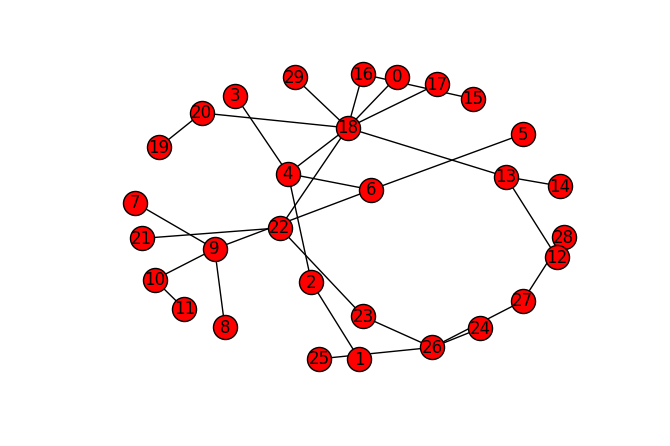

In [290]:
import matplotlib.pyplot as plt
nx.draw(graph, with_labels=True)
plt.show()

In [280]:
#sent = [('2', '1'), ('4', '2'), ('4', '3'), ('18', '4'), ('6', '5'), ('4', '6'), ('9', '7'), ('9', '8'), ('6', '9'), ('9', '10'), ('10', '11'), ('13', '12'), ('18', '13'), ('13', '14'), ('16', '15'), ('18', '16'), ('18', '17'), ('0', '18'), ('20', '19'), ('18', '20'), ('22', '21'), ('18', '22'), ('22', '23'), ('26', '24'), ('26', '25'), ('23', '26'), ('26', '27'), ('27', '28'), ('18', '29')]

In [281]:
#graph  = nx.Graph(sent)

In [261]:
#type(graph)

networkx.classes.graph.Graph

In [291]:
#nx.shortest_path_length(graph, source='10', target='11')

1

In [362]:
Associated_drug_temporal_data = pd.DataFrame(
    {'associated_dt': associated_list,
     'Temp_converted': temp_converted })

In [ ]:
Associated_drug_temporal_data.head()

In [363]:
Associated_drug_temporal_data.to_csv('Associated_drug_temporal_data_v6.csv' , index = False)

In [ ]:
Data_100_users_roll_up_v1 = pd.concat([df_75,Associated_drug_temporal_data],axis=1)

In [ ]:
Data_100_users_roll_up_v1.to_csv("Data_100_users_roll_up_v3.csv" , index = False)